In [1]:
cd ..

c:\Users\jeong\Desktop\python-practices\contrastive-triplet-practice


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.cuda
import torch.nn
import torch.nn.functional
import torch.optim
import torch.utils
import torch.utils.data
import torchvision
import torchvision.transforms

import reid.datasets.paired
import reid.losses
import reid.models
import reid.utilities

In [3]:
# Get Device
device = reid.utilities.device()
reid.utilities.manual_seed(777)

In [4]:
# Prepare Datasets
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Grayscale(),
    # torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
transform_inv = torchvision.transforms.Compose([
    # torchvision.transforms.Normalize((-1, -1, -1), (2, 2, 2)),
])

dataset = torchvision.datasets.ImageFolder('./data/atnt-faces/train',
                                                 transform=transform)
dataset_train = reid.datasets.paired.DoublePairedVisionDataset(
    dataset)
dataloader_train = torch.utils.data.DataLoader(dataset_train,
                                               batch_size=128*3,
                                               shuffle=True,
                                               num_workers=0)

In [5]:
# Create Model
model = reid.models.simple_cnn()
model.to(device)
criterion = reid.losses.ContrastiveLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
lr_sche = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

In [6]:
# Or Load
# model = reid.models.resnet18_custom(False)
# model.load_state_dict(torch.load('./model_epoch_49.pth'))
# model = model.to(device).eval()

In [7]:
# Train
loss_epoch = []
num_epochs = 60
for epoch in range(num_epochs):
    loss_batch = 0.0
    for i, batch in enumerate(dataloader_train, 0):
        inputs0, inputs1, labels = batch
        inputs0 = inputs0.to(device)
        inputs1 = inputs1.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        loss = criterion(model(inputs0), model(inputs1), labels)
        
        loss.backward()
        optimizer.step()

        # print statistics
        loss_batch += loss
    lr_sche.step()
    loss_batch /= i+1
    print(f'epoch: {epoch}, loss: {loss_batch}')
    loss_epoch.append(loss_batch)

    if epoch % 10 == 9:
        reid.utilities.save_model(model, f'contra_simple_faces_{epoch}')

epoch: 0, loss: 1.902712345123291
epoch: 1, loss: 1.9931445121765137
epoch: 2, loss: 1.7513833045959473
epoch: 3, loss: 1.3864506483078003
epoch: 4, loss: 1.3454362154006958
epoch: 5, loss: 1.3594905138015747
epoch: 6, loss: 1.2195968627929688
epoch: 7, loss: 1.679276704788208
epoch: 8, loss: 1.3401644229888916
epoch: 9, loss: 1.4572606086730957
epoch: 10, loss: 1.509783148765564
epoch: 11, loss: 1.403247356414795
epoch: 12, loss: 1.3573070764541626
epoch: 13, loss: 1.4626705646514893
epoch: 14, loss: 1.4862853288650513
epoch: 15, loss: 1.5057361125946045
epoch: 16, loss: 1.4818308353424072
epoch: 17, loss: 1.484856367111206
epoch: 18, loss: 1.3508214950561523
epoch: 19, loss: 1.321293592453003
epoch: 20, loss: 1.3484220504760742
epoch: 21, loss: 1.724579095840454
epoch: 22, loss: 1.3488662242889404
epoch: 23, loss: 1.2387257814407349
epoch: 24, loss: 1.2547359466552734
epoch: 25, loss: 1.3472537994384766
epoch: 26, loss: 1.3101893663406372
epoch: 27, loss: 1.1044621467590332
epoch: 28

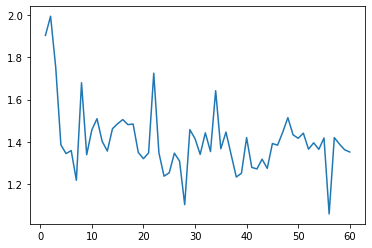

In [8]:
plt.plot(np.linspace(1, num_epochs, num_epochs).astype(int), loss_epoch)
plt.show()

In [9]:
# Test
def visualize_batch(model, batch, transform, device):
    anchors, others, labels = batch

    for i in range(len(anchors)):
        anchor = anchors[i].unsqueeze(dim=0).to(device)
        other = others[i].unsqueeze(dim=0).to(device)

        # calc distance between anchor and X
        output_anchor = model(anchor)
        output_other = model(other)
        distance = torch.nn.functional.pairwise_distance(
            output_anchor, output_other)

        # make grid
        imgs = torch.cat((transform(anchor), transform(other)), 0)
        plt.imshow(
            torchvision.utils.make_grid(imgs).cpu().permute(1, 2, 0))
        plt.text(75,
                 8,
                 'dist: {:.8f}'.format(distance.item()),
                 fontweight='bold',
                 bbox={
                     'facecolor': 'white',
                     'alpha': 0.8,
                     'pad': 10
                 })
        plt.show()

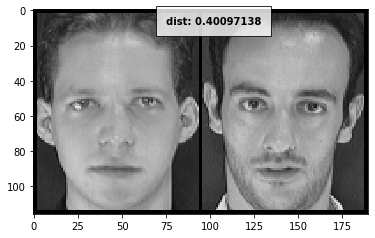

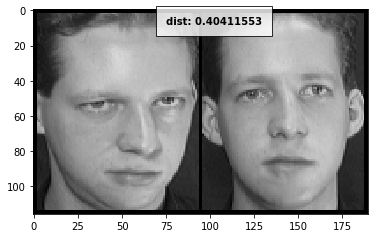

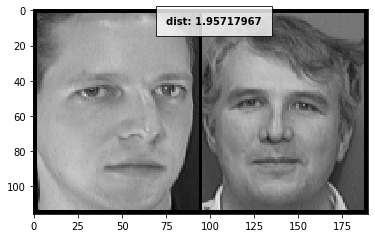

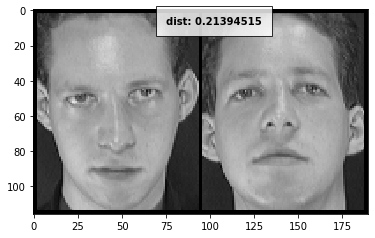

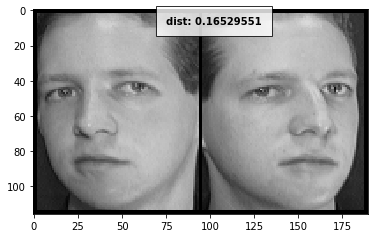

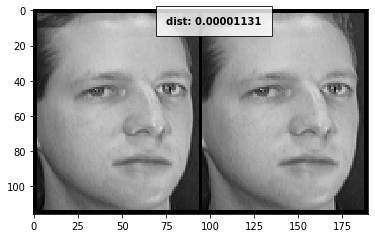

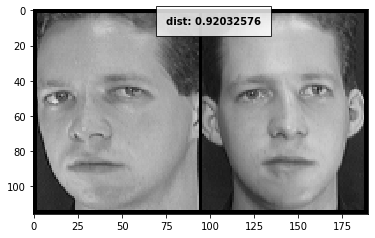

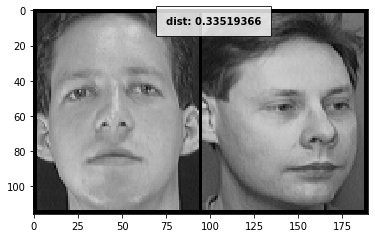

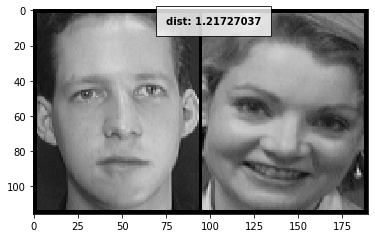

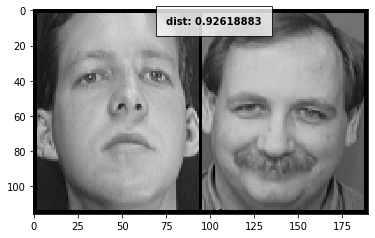

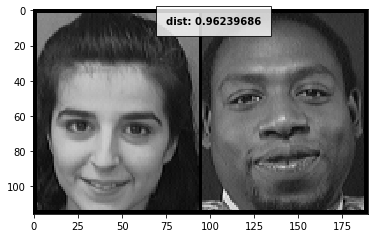

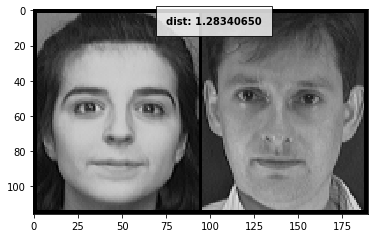

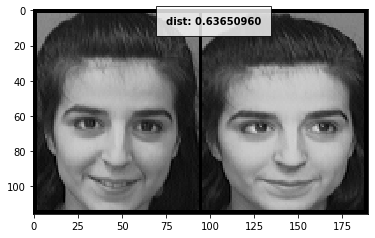

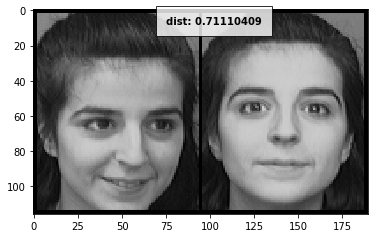

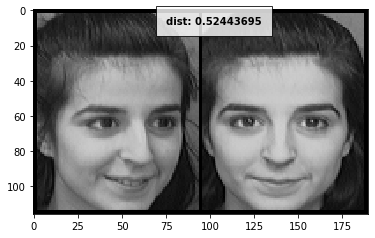

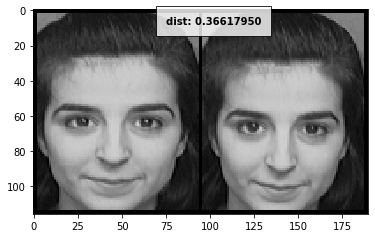

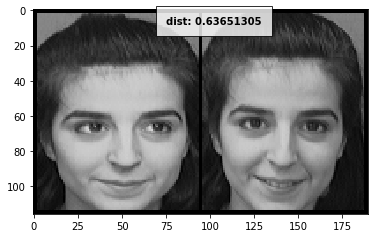

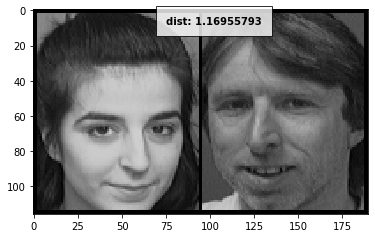

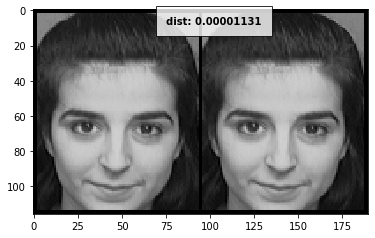

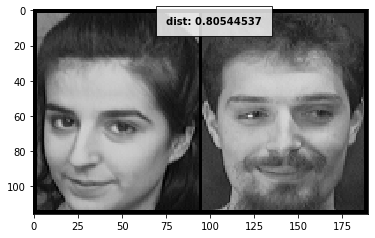

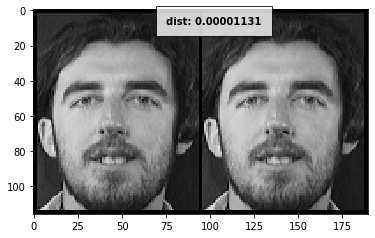

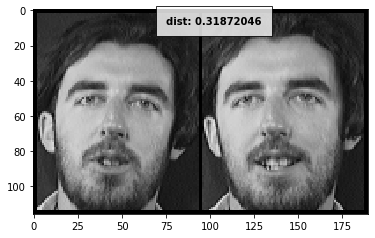

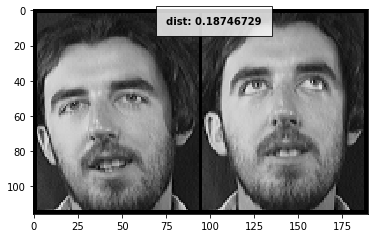

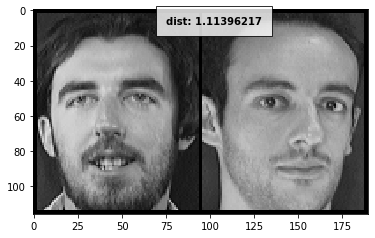

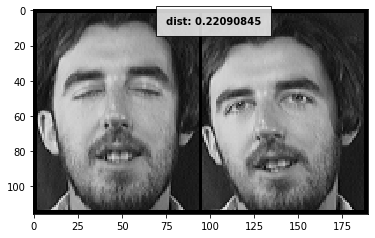

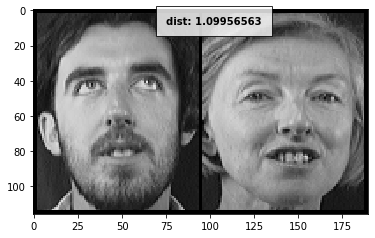

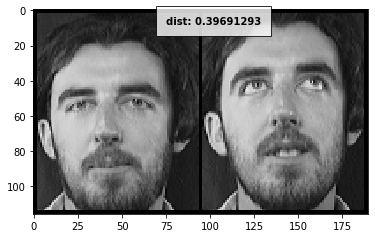

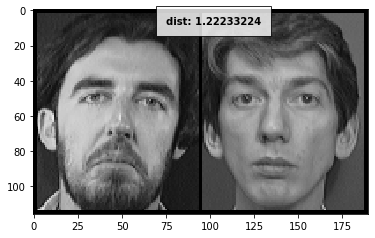

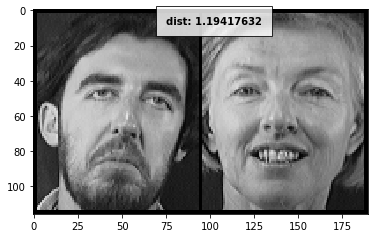

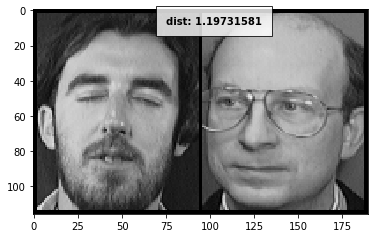

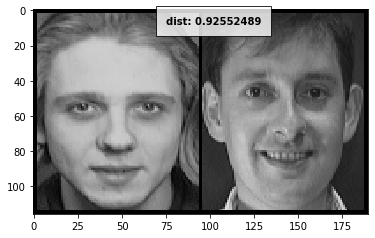

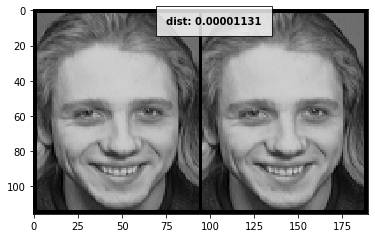

In [10]:
dataloader_test = torch.utils.data.DataLoader(dataset_train,
                                              batch_size=32,
                                              shuffle=False,
                                              num_workers=0)
batch = next(iter(dataloader_test))
visualize_batch(model, batch, transform_inv, device)

In [11]:
f'classes: {len(dataset_train._classes)}, size: {len(dataset_train)}'

'classes: 40, size: 400'